## Imports
**Please set up an environment with the necessary packages:** 
1. `python -m venv env` (or conda)
2. `source env/bin/activate`
3. `pip install pandas numpy sklearn matplotlib seaborn`

In [269]:
import requests
import csv
import json
import pandas as pd
import pprint
from enum import Enum
import numpy as np
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import seaborn as sns
import copy

sns.set()

## Set up data types and utilities

In [217]:
class Degree(Enum):
    BACHELORS="Bachelors"
    MASTERS="Masters"
    PHD="Phd"

class Gender(Enum):
    MALE="M"
    FEMALE="F"
    NOT_APPLICABLE="N/A"

class VeteranStatus(Enum):
    YES="1"
    NO="0"
    NOT_APPLICABLE="N/A"

class WorkAuthorization(Enum):
    YES="1"
    NO="0"

class Disability(Enum):
    YES="1"
    NO="0"
    NOT_APPLICABLE="N/A"

class Ethnicity(Enum):
    WHITE="0"
    BLACK="1"
    NATIVE_AMERICAN="2"
    ASIAN_AMERICAN_PACIFIC_ISLANDER="3"
    OTHER="4"

class InterviewDecision(Enum):
    YES="1"
    NO="0"

class Date:

    def __init__(self, month:int=-1, day:int=-1, not_applicable=False):
        self.not_applicable = not_applicable
        self.month = month
        self.day = day

    def __str__(self):
        if self.not_applicable:
            return "N/A"
        else:
            return str(self.month) + "/" + str(self.day)
        
    @classmethod  
    def from_str(cls, date_str):
        if date_str == "N/A":
            return cls(not_applicable=True)
        else:
            month, day = map(int, date_str.split("/"))
            return cls(month, day)

class Job:
    def __init__(self, role="N/A", start=Date(not_applicable=True), end=Date(not_applicable=True)):
        self.role = role
        self.start = start
        self.end = end

class Row:
    _applicant_id = 1

    def __init__(self,school_name:str, gpa:float, degree:Degree, location:str, gender:Gender, veteran_status:VeteranStatus, work_authorization:WorkAuthorization, disability:Disability, ethnicity:Ethnicity, jobs: list[Job], resume_score:float = None, interview_decision:InterviewDecision = None):
        self.applicant_id = Row._applicant_id
        Row._applicant_id += 1

        self.school_name = school_name
        self.gpa = gpa
        self.degree = degree
        self.location = location
        self.gender = gender
        self.veteran_status = veteran_status
        self.work_authorization = work_authorization
        self.disability = disability
        self.ethnicity = ethnicity
        self.jobs = jobs
        self.resume_score = resume_score
        self.interview_decision = interview_decision

def generate_csv(file_name, rows: list[Row], for_candidate_evaluator):
    field_names = ["Applicant ID", "School Name", "GPA", "Degree", "Location", "Gender", "Veteran status", "Work authorization", "Disability", "Ethnicity", "Role 1", "Start 1", "End 1", "Role 2", "Start 2", "End 2", "Role 3", "Start 3", "End 3"]
    if (for_candidate_evaluator):
        field_names.append("Resume score")
    with open(file_name + ".csv", 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=field_names, lineterminator="\n")
        writer.writeheader()
        for row in rows:
            csv_row = {
                "Applicant ID": row.applicant_id,
                "School Name": row.school_name,
                "GPA": row.gpa,
                "Degree": row.degree.value,
                "Location": row.location,
                "Gender": row.gender.value,
                "Veteran status": row.veteran_status.value,
                "Work authorization": row.work_authorization.value,
                "Disability": row.disability.value,
                "Ethnicity": row.ethnicity.value,
            }
            for i, job in enumerate(row.jobs):
                csv_row["Role " + str(i + 1)] = job.role
                csv_row["Start " + str(i + 1)] = str(job.start)
                csv_row["End " + str(i + 1)] = str(job.end)
            if for_candidate_evaluator:
                csv_row["Resume score"] = row.resume_score
            writer.writerow(csv_row)
    with open(file_name + ".csv", "rb+") as csvfile:
        csvfile.seek(-2, 2)
        csvfile.truncate()

def read_csv(file_name):
    rows = []
    with open(file_name, 'r') as csvfile:
        reader = csv.DictReader(csvfile)

        for row_dict in reader:
            # Parse basic fields
            school_name = row_dict["School Name"]
            gpa = float(row_dict["GPA"])
            degree = Degree(row_dict["Degree"])
            location = row_dict["Location"]
            gender = Gender(row_dict["Gender"])
            veteran_status = VeteranStatus(row_dict["Veteran status"])
            work_authorization = WorkAuthorization(row_dict["Work authorization"])
            disability = Disability(row_dict["Disability"])
            ethnicity = Ethnicity(row_dict["Ethnicity"])

            # Parse jobs
            jobs = []
            for i in range(1, 4):  # Assume up to 3 job entries
                role = row_dict.get(f"Role {i}", "N/A")  
                start_str = row_dict.get(f"Start {i}")
                end_str = row_dict.get(f"End {i}")

                start = Date.from_str(start_str)
                end = Date.from_str(end_str)
                jobs.append(Job(role, start, end))

            # Parse resume score (if it exists)
            resume_score = row_dict.get("Resume score", None)
            if resume_score != None:
                resume_score = float(resume_score)

            # Parse interview decision
            interview_decision = row_dict.get("Interview decision", None)
            if interview_decision != None:
                interview_decision = InterviewDecision(interview_decision)

            # Create Row object
            row = Row(school_name, gpa, degree, location, gender, 
                      veteran_status, work_authorization, disability, ethnicity, 
                      jobs, resume_score, interview_decision)
            rows.append(row)

    return rows


## Generate synthetic datasets
- Options:
  1. Each possible combination of categorical and numberical data
  2. Randomly sampled features (features are uncorrelated) 
- String values are set to empty string

In [218]:
categorical = {
    "degree": Degree, 
    "gender": Gender, 
    "ethnicity": Ethnicity, 
    "veteran_status": VeteranStatus, 
    "work_authorization": WorkAuthorization,
    "disability": Disability,
    "gpa": np.arange(2,4,0.1)
}

# generates every possible combination of features, leaving school and location as empty strings
def generate_combinations():
    grid = {}
    for key in categorical.keys():
        grid[key] = [e for e in categorical[key]]
    
    X = list(ParameterGrid(grid))
    rows = []
    for x in X:
        jobs = [Job(), Job(), Job()]
        r = Row("", np.round(x["gpa"], 1), x["degree"], "", x["gender"], x["veteran_status"], x["work_authorization"], x["disability"], x["ethnicity"], jobs)
        rows.append(r)
    return rows

In [219]:
def generate_candidates(num: int, gen_resume_score=False):
    rows = []
    for _ in range(num):
        degree = np.random.choice(
            [Degree.BACHELORS, Degree.MASTERS, Degree.PHD], 
            size=1,
        )[0]
        
        gender = np.random.choice(
            [Gender.FEMALE, Gender.MALE, Gender.NOT_APPLICABLE], 
            size=1, 
        )[0]
        
        ethnicity = np.random.choice(
            [Ethnicity.ASIAN_AMERICAN_PACIFIC_ISLANDER,Ethnicity.BLACK,Ethnicity.NATIVE_AMERICAN,Ethnicity.OTHER,Ethnicity.WHITE], 
            size=1, 
        )[0]
        
        veteran_status = np.random.choice(
            [VeteranStatus.YES, VeteranStatus.NO, VeteranStatus.NOT_APPLICABLE],
            size=1,
        )[0]
        
        work_authorization = np.random.choice(
            [WorkAuthorization.NO, WorkAuthorization.YES],
            size=1,
        )[0]
        
        # samples uniformly from 2.0 -> 4.0 in 0.1 increments
        gpa = np.random.choice(
            np.arange(2.0,4.1,0.1),
            size=1
        )[0]
        gpa = np.round(gpa, 1)
        
        # uniform over POSSIBLE_LOCATIONS
        location = ""
        
        # uniform over POSSIBLE_SCHOOLS
        school_name = ""
        
        disability = np.random.choice(
            [Disability.NO, Disability.YES, Disability.NOT_APPLICABLE],
            size=1,
        )[0]
        
        jobs = [Job(), Job(), Job()]
        
        resume_score = None
        if gen_resume_score:
            resume_score = np.round(np.random.random()*10, 2)
        
        r = Row(school_name, gpa, degree, location, gender, veteran_status, work_authorization, disability, ethnicity, jobs, resume_score)
        rows.append(r)
    return rows

In [220]:
rows = generate_combinations()
fname = "datasets/synthetic1"
generate_csv("datasets/synthetic1", rows, for_candidate_evaluator=False)
print(f"generated synthetic csv at {fname}.csv with {len(rows)} rows")

generated synthetic csv at datasets/synthetic1.csv with 16200 rows


In [221]:
rows_every_combo = read_csv("datasets/synthetic1.csv")
dataset_every_combo = pd.read_csv("datasets/synthetic1.csv", keep_default_na=False)
dataset_every_combo

,Applicant ID,School Name,GPA,Degree,Location,Gender,Veteran status,Work authorization,Disability,Ethnicity,Role 1,Start 1,End 1,Role 2,Start 2,End 2,Role 3,Start 3,End 3
0,1,,2.0,Bachelors,,M,1,1,1,0,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
1,2,,2.0,Bachelors,,M,1,0,1,0,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
2,3,,2.0,Bachelors,,M,0,1,1,0,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
3,4,,2.0,Bachelors,,M,0,0,1,0,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
4,5,,2.0,Bachelors,,M,N/A,1,1,0,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16195,16196,,3.9,Phd,,N/A,1,0,N/A,4,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
16196,16197,,3.9,Phd,,N/A,0,1,N/A,4,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
16197,16198,,3.9,Phd,,N/A,0,0,N/A,4,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
16198,16199,,3.9,Phd,,N/A,N/A,1,N/A,4,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A


In [258]:
rows = generate_candidates(800)
generate_csv("./datasets/synthetic2", rows, for_candidate_evaluator=False)
print("generated & wrote 800 candidates to datasets/synthetic2.csv")

Row._applicant_id = 1
rows_with_score = generate_candidates(800, gen_resume_score=True)
generate_csv("./datasets/synthetic_with_score", rows_with_score, for_candidate_evaluator=True)
print("generated & wrote 800 candidates to datasets/synthetic_with_score.csv")

generated & wrote 800 candidates to datasets/synthetic2.csv
generated & wrote 800 candidates to datasets/synthetic_with_score.csv


In [259]:
rows_random = read_csv("datasets/synthetic2.csv")
dataset_random = pd.read_csv("datasets/synthetic2.csv", keep_default_na=False)

rows_random_with_scores = read_csv("datasets/synthetic_with_score.csv")
dataset_random_with_scores = pd.read_csv("datasets/synthetic_with_score.csv", keep_default_na=False)

dataset_random_with_scores

,Applicant ID,School Name,GPA,Degree,Location,Gender,Veteran status,Work authorization,Disability,Ethnicity,Role 1,Start 1,End 1,Role 2,Start 2,End 2,Role 3,Start 3,End 3,Resume score
0,1,,3.3,Phd,,N/A,N/A,1,1,1,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,2.31
1,2,,2.8,Phd,,M,1,1,N/A,3,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,0.82
2,3,,3.0,Masters,,N/A,0,0,1,3,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,5.03
3,4,,2.2,Bachelors,,F,N/A,1,N/A,3,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,4.36
4,5,,2.0,Phd,,F,N/A,0,0,2,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,7.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,796,,3.6,Phd,,M,1,0,0,4,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,3.27
796,797,,3.9,Masters,,N/A,N/A,0,0,1,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,6.50
797,798,,3.9,Bachelors,,M,1,1,1,2,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,9.28
798,799,,2.4,Phd,,N/A,1,0,0,1,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,0.04


## Set up function to query endpoints

In [260]:
resume_scorer_endpoint = "https://jennjwang.pythonanywhere.com"
candidate_evaluator_endpoint = "https://heonlee.pythonanywhere.com"

def csv_to_json(fname):     
    with open(fname, encoding='utf-8') as csvf:
        csvReader = csv.DictReader(csvf)
         
        data = [row for row in csvReader] 
    
    return json.dumps(data)

def query(endpoint, json_str):
    response = requests.post(endpoint, data=json_str, headers={
        "Content-Type": "application/json"
    })
    
    if response.status_code == 200:
        pred = json.loads(response.text)['prediction']
        return json.loads(pred)
    else:
        print(f"error on post to {endpoint}, {response}")

In [261]:
json_string = csv_to_json("datasets/synthetic2.csv")

print("Sending dataset to endpoint...")
result = query(resume_scorer_endpoint, json_string)
print()
print(len(result), result[:5])

Sending dataset to endpoint...

800 [{'applicant_id': '2701', 'score': '6.66'}, {'applicant_id': '2702', 'score': '7.01'}, {'applicant_id': '2703', 'score': '3.12'}, {'applicant_id': '2704', 'score': '0.72'}, {'applicant_id': '2705', 'score': '5.47'}]


## Measure Resume Scorer Selection Rates

In [262]:
# compute feature importances across dataset
def generate_master_rows(feature_enum, feature_name, rows):
    # create a dataset for each value feature can take
    # all the same except for the feature value
    values = [e for e in feature_enum]
    
    master_rows = []
    for v in values:
        new_rows = copy.deepcopy(rows)
        for r in new_rows:
            setattr(r, feature_name, v)
        master_rows.extend(new_rows)
            
    return master_rows
    
# mean the selection rate of each
def measure_selection_rates(feature_enum, feature_name, master_rows, results):
    values = [e.value for e in feature_enum]
    
    # split df into each
    n_each = len(master_rows) // len(values)
        
    selection_rates = {}
    for i, v in enumerate(values):
        start, end = i*n_each, i*n_each+n_each
        sub_rows = results[start:end]
        selection_rates[v] = np.mean(sub_rows)

    return selection_rates

In [263]:
feature_enums = [Degree, Ethnicity, WorkAuthorization, Disability, VeteranStatus, Gender]
feature_names = ["degree", "ethnicity", "work_authorization", "disability", "vereran_status", "gender"]

rows_to_use = copy.deepcopy(rows_random)

selection_rates_resume_scorer = {}
for feature_enum, feature_name in zip(feature_enums, feature_names):
    print("auditing "+feature_name+"...")
    rows_to_use = copy.deepcopy(rows_random)
    master_rows = generate_master_rows(feature_enum, feature_name, rows_to_use)
    fname = f"datasets/test_df_{feature_name}"
    generate_csv(fname, master_rows, for_candidate_evaluator=False)

    json_str = csv_to_json(fname+".csv")
    results = query(resume_scorer_endpoint, json_str)
    scores = [float(applicant["score"]) for applicant in results]

    rates = measure_selection_rates(feature_enum, feature_name, master_rows, scores)
    selection_rates_resume_scorer[feature_name] = rates

pprint.pp(selection_rates_resume_scorer)

auditing degree...
auditing ethnicity...
auditing work_authorization...
auditing disability...
auditing vereran_status...
auditing gender...
{'degree': {'Bachelors': 4.9869375, 'Masters': 5.0523125, 'Phd': 5.0126625},
 'ethnicity': {'0': 4.9289375,
               '1': 5.0673,
               '2': 4.9908874999999995,
               '3': 5.006687499999999,
               '4': 5.1781500000000005},
 'work_authorization': {'1': 5.10925, '0': 4.94405},
 'disability': {'1': 4.9308499999999995,
                '0': 4.949825000000001,
                'N/A': 5.009825000000001},
 'vereran_status': {'1': 4.9122375, '0': 4.9558, 'N/A': 4.8849},
 'gender': {'M': 4.988125, 'F': 5.169837500000001, 'N/A': 4.996575}}


## Measure Interview Model Selection Rates

In [265]:
rows_to_use = copy.deepcopy(rows_random_with_scores)

selection_rates_interview_model = {}
for feature_enum, feature_name in zip(feature_enums, feature_names):
    print("auditing "+feature_name+"...")
    rows_to_use = copy.deepcopy(rows_random)
    master_rows = generate_master_rows(feature_enum, feature_name, rows_to_use)
    fname = f"datasets/test_df_{feature_name}"
    generate_csv(fname, master_rows, for_candidate_evaluator=True)

    json_str = csv_to_json(fname+".csv")
    results = query(candidate_evaluator_endpoint, json_str)
    preds = [float(applicant["prediction"]) for applicant in results]

    rates = measure_selection_rates(feature_enum, feature_name, master_rows, preds)
    selection_rates_interview_model[feature_name] = rates

pprint.pp(selection_rates_interview_model)

auditing degree...
auditing ethnicity...
auditing work_authorization...
auditing disability...
auditing vereran_status...
auditing gender...
{'degree': {'Bachelors': 0.33125, 'Masters': 0.31875, 'Phd': 0.33},
 'ethnicity': {'0': 0.315, '1': 0.2975, '2': 0.325, '3': 0.32125, '4': 0.3475},
 'work_authorization': {'1': 0.32875, '0': 0.33125},
 'disability': {'1': 0.3275, '0': 0.37875, 'N/A': 0.32125},
 'vereran_status': {'1': 0.33125, '0': 0.32375, 'N/A': 0.33375},
 'gender': {'M': 0.59125, 'F': 0.3975, 'N/A': 0.0}}


## Plots and Analysis

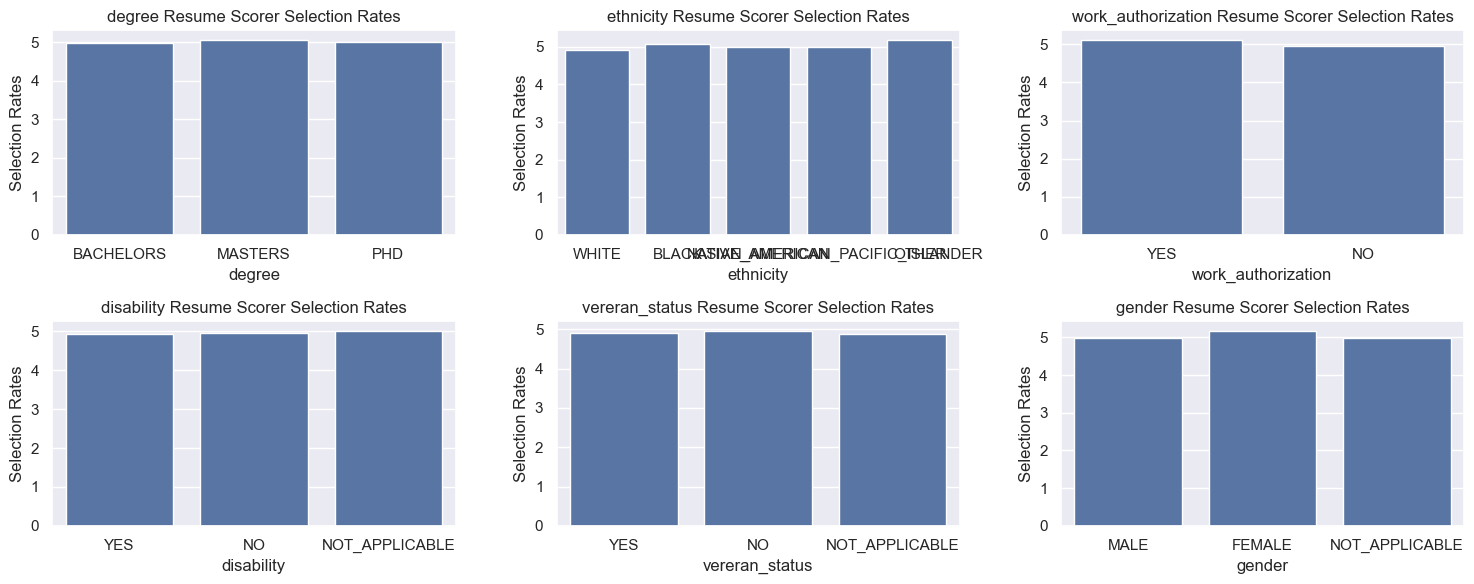

In [276]:
num_cols = 3
num_rows = -(-len(feature_enums) // num_cols) 

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3*num_rows))

for i, (feature_enum, feature_name) in enumerate(zip(feature_enums, feature_names)):
    row = i // num_cols
    col = i % num_cols
    
    data = {'Category': [], 'Values': []}
    for cat, v in zip(feature_enum.__members__.keys(), selection_rates_resume_scorer[feature_name].values()):
        data['Category'].append(cat)
        data['Values'].append(v)
    
    df = pd.DataFrame(data)
    ax = axes[row, col] if num_rows > 1 else axes[col]
    sns.barplot(x='Category', y='Values', data=df, ax=ax)
    ax.set_title(f"{feature_name} Resume Scorer Selection Rates")
    ax.set_xlabel(feature_name)
    ax.set_ylabel("Selection Rates")

plt.tight_layout()
plt.show()